In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lib.data import generate_top_n_for_all_users, get_ratings, get_predictions, get_top_n, get_relevant_items_for_user, set_items, get_users, set_ratings, set_predictions, get_cold_users

# Metric Imports
from lib.availability import availability_for_user
from lib.coverage import is_user_covered, category_coverage_for_user
from lib.diversity import intralist_price_diversity_for_user, intralist_category_diversity_for_user
from lib.mrr import mrr_for_user
from lib.precision import mean_average_precision_for_user
from lib.rmse import rmse_for_user
from lib.serendipity import serendipity_for_user
from lib.ndcg import ndcg

from lib.utils import read_items_from_file, read_ratings_from_file, read_predictions_from_file, calculate_statistics, generate_output_files

In [2]:
ALGORITHMS = ['cbf', 'item-item', 'mf', 'perbias', 'user-user']

SINGLEVALUE_METRICS = ['Coverage.Item', 'Coverage.User']
MULTIVALUE_METRICS = ['Availability', 'MRR', 'Serendipity',
                    'MAP', 'RMSE.Predict', 'RMSE.TopN', 'nDCG', 'Diversity.Price', 'Diversity.Category']

ratings = read_ratings_from_file()
set_ratings(ratings)
ITEMS = read_items_from_file()
set_items(ITEMS)
ALL_CATEGORIES = set(map(lambda x: x['Category'], ITEMS))

In [3]:
results = {}

for metric in (SINGLEVALUE_METRICS + MULTIVALUE_METRICS):
  results[metric] = {}

for algorithm in ALGORITHMS:
  predictions = read_predictions_from_file(algorithm)
  set_predictions(predictions)

  users = get_cold_users()
  generate_top_n_for_all_users(users)

  items_recommended = set()
  users_covered = 0.0

  availability_values = []
  mrr_values = []
  serendipity_values = []
  map_values = []
  rmse_predict_values = []
  rmse_top_values = []
  ndcg_values = []
  diversity_price_values = []
  diversity_category_values = []

  for user_id in users:
    top_n = get_top_n(user_id, 5)
    user_ratings = get_ratings(user_id)
    user_relevant_items = get_relevant_items_for_user(user_id)
    user_predictions = get_predictions(user_id)

    # Coverage Metrics
    items_recommended = items_recommended | set(top_n['Item'])

    if is_user_covered(top_n):
      users_covered += 1.0

    # Other metrics
    availability_values.append(availability_for_user(top_n))
    mrr_values.append(mrr_for_user(top_n, user_relevant_items))
    serendipity_values.append(serendipity_for_user(top_n, user_id))
    map_values.append(mean_average_precision_for_user(top_n, user_id))
    rmse_predict_values.append(rmse_for_user(user_id, user_ratings, user_predictions))
    rmse_top_values.append(rmse_for_user(user_id, user_ratings, top_n))
    ndcg_values.append(ndcg(user_id, top_n))
    diversity_price_values.append(intralist_price_diversity_for_user(top_n))
    diversity_category_values.append(intralist_category_diversity_for_user(top_n))

  results['Availability'][algorithm] = calculate_statistics(availability_values, algorithm)
  results['MRR'][algorithm] = calculate_statistics(mrr_values, algorithm)
  results['Serendipity'][algorithm] = calculate_statistics(serendipity_values, algorithm)
  results['MAP'][algorithm] = calculate_statistics(map_values, algorithm)
  results['RMSE.Predict'][algorithm] = calculate_statistics(rmse_predict_values, algorithm)
  results['RMSE.TopN'][algorithm] = calculate_statistics(rmse_top_values, algorithm)
  results['nDCG'][algorithm] = calculate_statistics(ndcg_values, algorithm)
  results['Diversity.Price'][algorithm] = calculate_statistics(diversity_price_values, algorithm)
  results['Diversity.Category'][algorithm] = calculate_statistics(diversity_category_values, algorithm)

  results['Coverage.Item'][algorithm] = [float(len(items_recommended))/float(len(ITEMS))]
  results['Coverage.User'][algorithm] = [users_covered/float(len(users))]

results['Availability'] = pd.concat([results['Availability'][algorithm] for algorithm in ALGORITHMS])
results['MRR'] = pd.concat([results['MRR'][algorithm] for algorithm in ALGORITHMS])
results['Serendipity'] = pd.concat([results['Serendipity'][algorithm] for algorithm in ALGORITHMS])
results['MAP'] = pd.concat([results['MAP'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.Predict'] = pd.concat([results['RMSE.Predict'][algorithm] for algorithm in ALGORITHMS])
results['RMSE.TopN'] = pd.concat([results['RMSE.TopN'][algorithm] for algorithm in ALGORITHMS])
results['nDCG'] = pd.concat([results['nDCG'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Price'] = pd.concat([results['Diversity.Price'][algorithm] for algorithm in ALGORITHMS])
results['Diversity.Category'] = pd.concat([results['Diversity.Category'][algorithm] for algorithm in ALGORITHMS])

In [4]:
colors= ['g', 'b', 'r', 'y', 'purple']
labels = ['Content Based Filtering', 'Item-Item CF', 'Matrix Factorization', 'Personalized Bias', 'User-User CB']

width = 10 # inch
aspect = 0.8 # height/width ratio
height = width*aspect
plt.rcParams['figure.figsize'] = [width, height]

n_groups = 1
index = np.arange(n_groups)
bar_width = 0.35

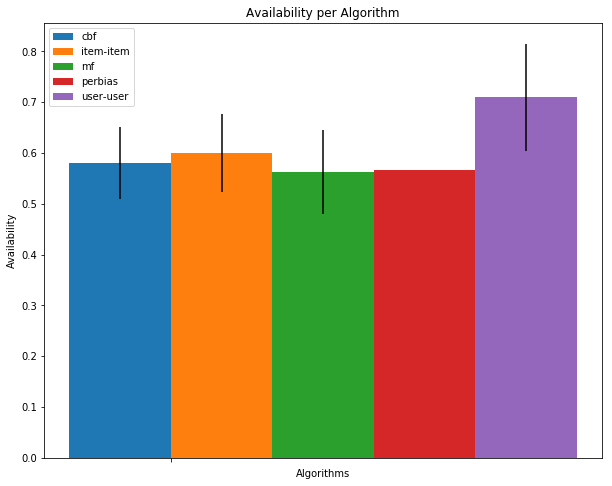

In [5]:
metric = results['Availability']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Availability')
ax.set_title('Availability per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [6]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.510899,0.531664,0.566868,0.604401,0.780201,0.802512,0.580693,0.508016,0.071108
item-item,0.534962,0.542552,0.599897,0.634643,0.790161,0.807144,0.599560,0.462140,0.077003
mf,0.468187,0.490999,0.531498,0.637614,0.684572,0.684572,0.561798,0.468187,0.082886
perbias,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.566868,0.000000
user-user,0.571730,0.644749,0.718888,0.763165,0.912630,0.918805,0.709562,0.515841,0.105426


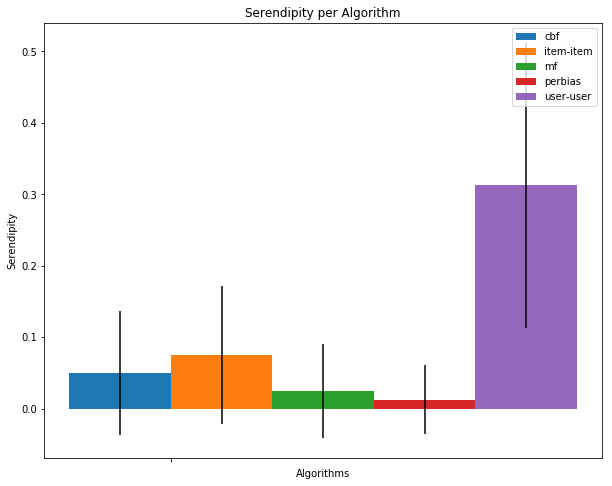

In [7]:
metric = results['Serendipity']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Serendipity')
ax.set_title('Serendipity per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [8]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.0,0.0,0.0,0.05,0.20,0.2,0.0500,0.0,0.086603
item-item,0.0,0.0,0.0,0.20,0.20,0.2,0.0750,0.0,0.096825
mf,0.0,0.0,0.0,0.00,0.20,0.2,0.0250,0.0,0.066144
perbias,0.0,0.0,0.0,0.00,0.17,0.2,0.0125,0.0,0.048412
user-user,0.1,0.2,0.2,0.45,0.60,0.6,0.3125,0.0,0.199609


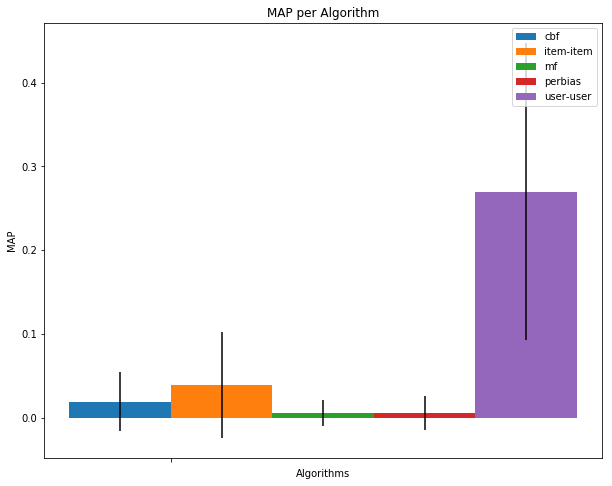

In [9]:
metric = results['MAP']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('MAP')
ax.set_title('MAP per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [10]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.00,0.000000,0.000000,0.012500,0.100000,0.100000,0.019097,0.0,0.035135
item-item,0.00,0.000000,0.000000,0.058333,0.195000,0.200000,0.038889,0.0,0.063221
mf,0.00,0.000000,0.000000,0.000000,0.052778,0.055556,0.005787,0.0,0.015657
perbias,0.00,0.000000,0.000000,0.000000,0.070833,0.083333,0.005208,0.0,0.020172
user-user,0.02,0.135417,0.301389,0.398611,0.542500,0.550000,0.270035,0.0,0.177721


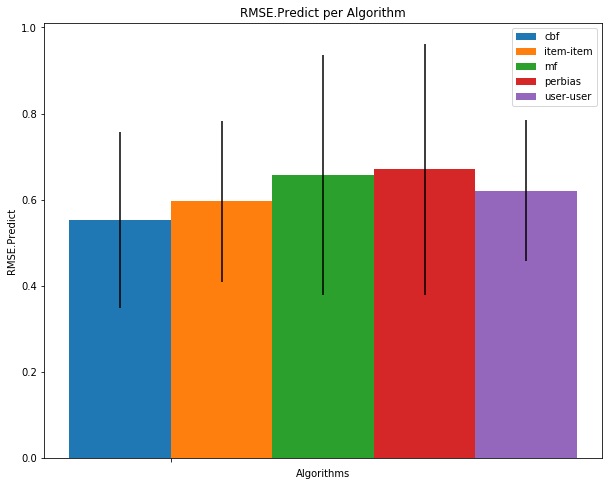

In [11]:
metric = results['RMSE.Predict']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.Predict')
ax.set_title('RMSE.Predict per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [12]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.335850,0.406852,0.480029,0.689760,0.996271,1.017527,0.552030,0.266683,0.205055
item-item,0.374872,0.452340,0.546364,0.717814,0.976962,0.991441,0.595775,0.359087,0.187695
mf,0.381236,0.456333,0.530124,0.839276,1.229491,1.258139,0.656679,0.311749,0.279411
perbias,0.388938,0.459293,0.542350,0.841719,1.339938,1.389332,0.670105,0.344744,0.292320
user-user,0.455000,0.543192,0.598944,0.674195,0.997065,1.027937,0.620934,0.320745,0.164500


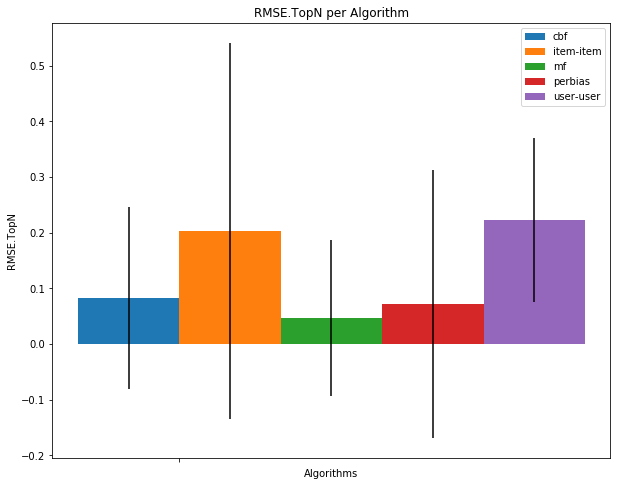

In [13]:
metric = results['RMSE.TopN']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('RMSE.TopN')
ax.set_title('RMSE.TopN per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [14]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.00000,0.000000,0.000000,0.025341,0.496510,0.505713,0.082809,0.0,0.163662
item-item,0.00000,0.000000,0.000000,0.280044,1.104627,1.143694,0.203369,0.0,0.338037
mf,0.00000,0.000000,0.000000,0.000000,0.502663,0.558041,0.046681,0.0,0.139689
perbias,0.00000,0.000000,0.000000,0.000000,0.868946,0.993779,0.072208,0.0,0.241127
user-user,0.03527,0.122713,0.208147,0.331367,0.505924,0.524713,0.222774,0.0,0.147021


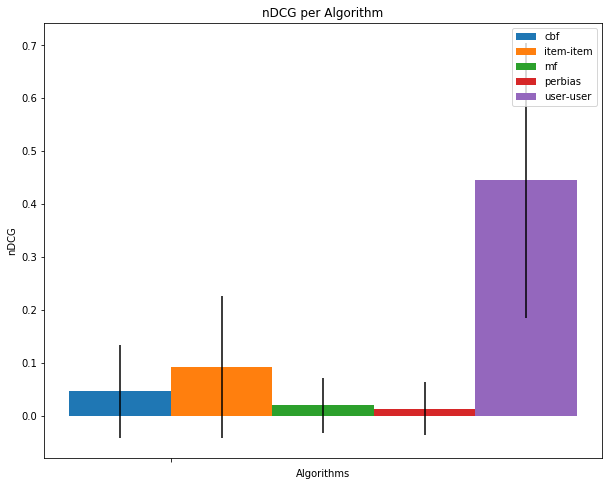

In [15]:
metric = results['nDCG']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('nDCG')
ax.set_title('nDCG per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [16]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.000000,0.000000,0.000000,0.031007,0.289048,0.310737,0.045875,0.0,0.087886
item-item,0.000000,0.000000,0.000000,0.177535,0.408087,0.416739,0.091912,0.0,0.134313
mf,0.000000,0.000000,0.000000,0.000000,0.161297,0.163175,0.019614,0.0,0.051942
perbias,0.000000,0.000000,0.000000,0.000000,0.176011,0.207072,0.012942,0.0,0.050124
user-user,0.057723,0.279984,0.478833,0.711700,0.772299,0.779837,0.444785,0.0,0.260098


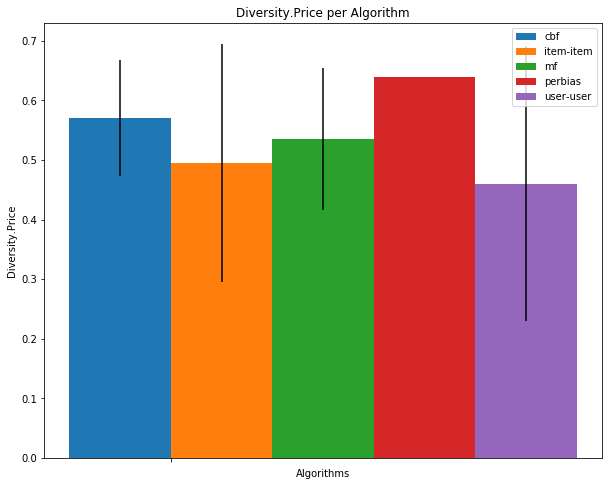

In [17]:
metric = results['Diversity.Price']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Price')
ax.set_title('Diversity.Price per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [18]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.44,0.54,0.64,0.64,0.64,0.64,0.570,0.32,0.097468
item-item,0.24,0.38,0.56,0.64,0.72,0.72,0.495,0.00,0.200437
mf,0.40,0.40,0.64,0.64,0.64,0.64,0.535,0.40,0.119059
perbias,0.64,0.64,0.64,0.64,0.64,0.64,0.640,0.64,0.000000
user-user,0.12,0.30,0.56,0.64,0.72,0.72,0.460,0.00,0.230651


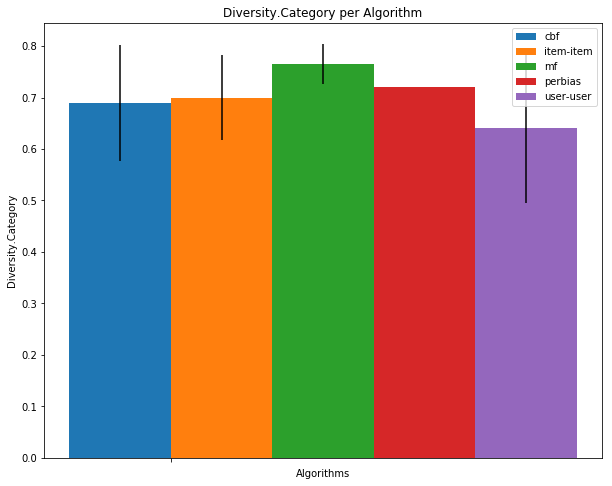

In [19]:
metric = results['Diversity.Category']

fig, ax = plt.subplots()

for i in range(0, len(ALGORITHMS)):
    algorithm = ALGORITHMS[i]
    bar = ax.bar(index + i*bar_width, metric.loc[algorithm]['mean'], 
                 width=bar_width, yerr=metric.loc[algorithm]['std'], label=algorithm, tick_label='')
    

ax.set_xlabel('Algorithms')
ax.set_ylabel('Diversity.Category')
ax.set_title('Diversity.Category per Algorithm')
ax.set_xticks(index + bar_width / 2)
ax.legend()

plt.show()

In [20]:
metric

,10,25,50,75,99,max,mean,min,std
cbf,0.60,0.70,0.72,0.72,0.80,0.80,0.690,0.32,0.112694
item-item,0.56,0.64,0.72,0.74,0.80,0.80,0.700,0.56,0.082462
mf,0.72,0.72,0.80,0.80,0.80,0.80,0.765,0.72,0.039686
perbias,0.72,0.72,0.72,0.72,0.72,0.72,0.720,0.72,0.000000
user-user,0.44,0.56,0.72,0.72,0.80,0.80,0.640,0.32,0.144222
